# Code to generate RDMs for time averaged stimuli for review rebuttal

In [45]:
import numpy as np 
import h5py
from pathlib import Path 
import IPython.display as ipd 
import pickle 
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import copy
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [ ]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
outdir = Path("rebuttal_figs")
outdir.mkdir(parents=True, exist_ok=True)

In [ ]:
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

def pearson_r(X, Y):
    X = np.asarray(X)
    Y = np.asarray(Y)
    if X.shape != Y.shape:
        raise ValueError(f"Shape mismatch: X{X.shape} vs Y{Y.shape}")

    Xc = X - X.mean(axis=1, keepdims=True)
    Yc = Y - Y.mean(axis=1, keepdims=True)

    Xnorm = np.linalg.norm(Xc, axis=1)
    Ynorm = np.linalg.norm(Yc, axis=1)
    denom = Xnorm * Ynorm

    num = np.sum(Xc * Yc, axis=1)

    with np.errstate(invalid='ignore', divide='ignore'):
        r_rows = num / denom
    r_rows[denom == 0] = np.nan

    # average over valid rows
    if np.all(np.isnan(r_rows)):
        return np.nan
    return np.nanmean(r_rows)


def pearson_r_torch(X, Y):
    if X.shape != Y.shape:
        raise ValueError(f"Shape mismatch: X{X.shape} vs Y{Y.shape}")
    
    Xc = X - X.mean(dim=1, keepdim=True)
    Yc = Y - Y.mean(dim=1, keepdim=True)

    Xnorm = torch.norm(Xc, dim=1)
    Ynorm = torch.norm(Yc, dim=1)
    denom = Xnorm * Ynorm

    num = torch.sum(Xc * Yc, dim=1)
    r_rows = num / denom

    # Mask invalid values (division by zero)
    r_rows = torch.where(denom == 0, torch.tensor(float('nan'), device=X.device), r_rows)

    # Average over valid (non-NaN) rows
    if torch.isnan(r_rows).all():
        return float('nan')
    
    return torch.nanmean(r_rows).item()


def l2_dist(X, Y):
    X = np.asarray(X)
    Y = np.asarray(Y)
    if X.shape != Y.shape:
        raise ValueError(f"Shape mismatch: X{X.shape} vs Y{Y.shape}")
    diffs = X - Y                       # (N, D)
    row_norms = np.linalg.norm(diffs, axis=1)  # (N,)
    return float(row_norms.mean())


def l2_dist_torch(X, Y):
    if X.shape != Y.shape:
        raise ValueError(f"Shape mismatch: X{X.shape} vs Y{Y.shape}")
    
    diffs = X - Y
    row_norms = torch.norm(diffs, dim=1)
    return row_norms.mean().item()


def plot_lower_triangle(matrix, title, xtick_labels=None, ytick_labels=None, xlabel="Location", ylabel="Location", cmap='viridis', vmin=None, vmax=None, symmetric=False, ax=None):
    mask = np.zeros_like(matrix) if symmetric else ~np.tril(np.ones_like(matrix, dtype=bool), k=0)
    masked = np.ma.masked_array(matrix, mask=mask)
    if xtick_labels != None and ytick_labels == None:
        ytick_labels = xtick_labels
    if ytick_labels != None and xtick_labels == None:
        xtick_labels = ytick_labels
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))  # Use fig and ax to control layout better
    if vmin is not None and vmax is not None:
        im = ax.imshow(masked, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        im = ax.imshow(masked, cmap=cmap, vmin=np.nanmin(masked), vmax=np.nanmax(masked))

    # Create colorbar axis with matching height
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)  # Use cax here

    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=90)
    ax.set_yticks(np.arange(len(ytick_labels)))
    ax.set_yticklabels(ytick_labels)

    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if ax is None:
        sns.despine(ax=ax)
        plt.tight_layout()
        plt.show()
    return ax

# Run RDMs with full representation for azimuth conditions

In [46]:
embeddings_path = "/om/scratch/Thu/imgriff/acts_for_RDM_analysis/word_task_v10_main_feature_gain_config/word_task_v10_main_feature_gain_config_model_activations_0dB_coch_only.h5"

embeddings = h5py.File(embeddings_path, 'r')
embeddings.keys()


<KeysViewHDF5 ['attncoch_gains', 'cochleagram_corr_uncued_mixture_diff_sex_v_target', 'cochleagram_corr_uncued_mixture_nat_scene_v_target', 'cochleagram_corr_uncued_mixture_same_sex_v_target', 'cochleagram_cue', 'cochleagram_diff_sex_sig', 'cochleagram_l2_norm_uncued_mixture_diff_sex_v_target', 'cochleagram_l2_norm_uncued_mixture_nat_scene_v_target', 'cochleagram_l2_norm_uncued_mixture_same_sex_v_target', 'cochleagram_mixture_diff_sex', 'cochleagram_mixture_nat_scene', 'cochleagram_mixture_same_sex', 'cochleagram_nat_scene_sig', 'cochleagram_same_sex_sig', 'cochleagram_target', 'diff_dist_f0', 'distractor_loc', 'same_dist_f0', 'target_f0', 'target_loc', 'target_word_int', 'tested_azims', 'tested_elevs']>

In [47]:
layer_names = [
            'cochleagram',
            'norm_coch_rep',
            'attn0',
            'conv_block_0_ln',
            'conv_block_0_relu',
            'hann_pool_0',
            'attn1',
            'conv_block_1_ln',
            'conv_block_1_relu',
            'hann_pool_1',
            'attn2',
            'conv_block_2_ln',
            'conv_block_2_relu',
            'hann_pool_2',
            'attn3',
            'conv_block_3_ln',
            'conv_block_3_relu',
            'hann_pool_3',
            'attn4',
            'conv_block_4_ln',
            'conv_block_4_relu',
            'hann_pool_4',
            'attn5',
            'conv_block_5_ln',
            'conv_block_5_relu',
            'hann_pool_5',
            'attn6',
            'conv_block_6_ln',
            'conv_block_6_relu',
            'hann_pool_6',
            'attnfc',
            'relufc']

signal_names = ['cue', 'target', 'same_sex_sig', 'diff_sex_sig', 'nat_scene_sig', 'mixture_same_sex', 'mixture_diff_sex', 'mixture_nat_scene']

attn_type = ['single_source', 'cued']

In [48]:
target_locs = embeddings['target_loc']
target_f0s = embeddings['target_f0']
single_src_coch_reps = embeddings['cochleagram_target']
print(single_src_coch_reps.shape)

(2500, 1600000)


In [13]:
unique_locs = np.unique(target_locs, axis=0)

loc_to_idx = {}
# create map of unique locations to index
for loc in unique_locs:
    rows = np.where(np.all(target_locs == loc, axis=1))[0]
    loc_to_idx[tuple(loc)] = rows

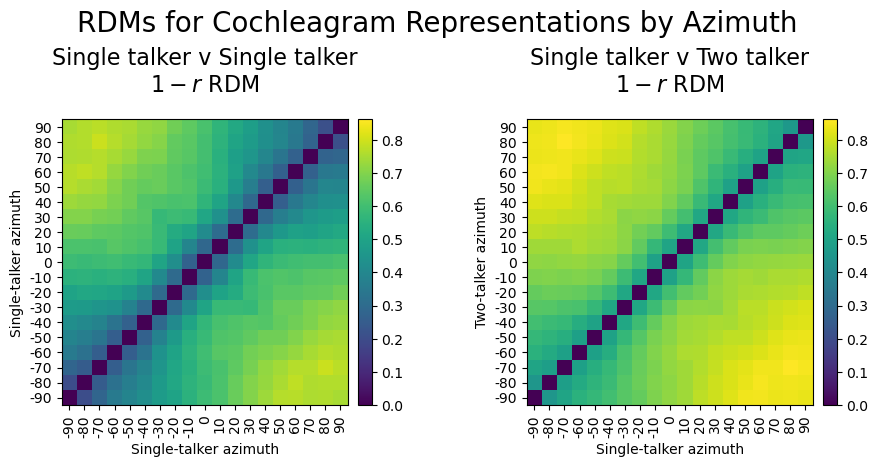

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Raw (unconverted) numpy embeddings
single_src_coch_reps= embeddings['cochleagram_target']
multi_src_coch_reps  = embeddings['cochleagram_mixture_same_sex']

# --- collect azimuths ---
all_locs = list(loc_to_idx.keys())
azims = [loc for loc in all_locs if (loc[1] == 0)]

# Sort azimuths by angle (wrap-around at ±180)
azimuths = sorted(azims, key=lambda x: (x[0] + 180) % 360 - 180)

# Create azimuth labels
loc_labels = []
for (azim, elev) in azimuths:
    if azim > 180:
        azim -= 360
    loc_labels.append(f"{azim:.0f}")

# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
n = len(azimuths)

xlabel = "Single-talker azimuth"
pearson_r_matrix = np.full((2, n, n), np.nan, dtype=float)
# l2_dist_matrix  = np.full((2, n, n), np.nan, dtype=float)

for plt_i in range(2):
    for i in range(n):
        i_idx = loc_to_idx[azimuths[i]]
        Xi_np = single_src_coch_reps[i_idx]  # (N, D)
        Xi = torch.tensor(Xi_np, dtype=torch.float32, device=device)

        pearson_r_matrix[plt_i, i, i] = 0.0  # r = 1 → 1 - r = 0
        # l2_dist_matrix[plt_i, i, i]   = 0.0

        for j in range(i):
            j_idx = loc_to_idx[azimuths[j]]
            if plt_i == 0:
                Xj_np = single_src_coch_reps[j_idx]
            else:
                Xj_np = multi_src_coch_reps[j_idx]
            Xj = torch.tensor(Xj_np, dtype=torch.float32, device=device)

            r = pearson_r_torch(Xi, Xj)
            # d = l2_dist_torch(Xi, Xj)

            pearson_r_matrix[plt_i, i, j] = pearson_r_matrix[plt_i, j, i] = 1 - r
            # l2_dist_matrix[plt_i, i, j]   = l2_dist_matrix[plt_i, j, i]   = d


azim_vmin = np.nanmin(pearson_r_matrix)
azim_vmax = np.nanmax(pearson_r_matrix)

# flip columns so diagonal goes bottom to top 
pearson_r_matrix = np.flip(pearson_r_matrix, axis=1)

for plt_i in range(2):
    ylabel = "Single-talker azimuth" if plt_i == 0 else "Two-talker azimuth"
    panel_title = "Single talker v Single talker" if plt_i == 0 else "Single talker v Two talker"
    # flip columns 
    plot_lower_triangle(pearson_r_matrix[plt_i,:,:],
                        f"{panel_title}\n$1-r$ RDM", 
                        xtick_labels=loc_labels,
                        ytick_labels=loc_labels[::-1],
                        xlabel=xlabel, ylabel=ylabel,
                        cmap='viridis', ax=axes[plt_i], vmin=azim_vmin, vmax=azim_vmax, symmetric=True)

plt.suptitle("RDMs for Cochleagram Representations by Azimuth", fontsize=20, y=1)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.savefig(outdir / "cochleagram_azim_rdm.pdf", bbox_inches='tight', transparent=True)

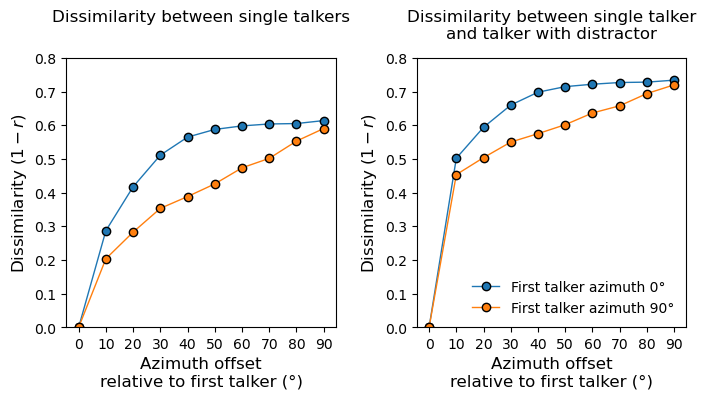

In [50]:
#### Add line plots 

fig, axs = plt.subplots(1,2,figsize=(8,3.5))

fontsize=12

ix_map = {}
for azim in [0, 90]:
    ix_map[azim] = np.where(np.array([loc[0] for loc in azimuths]) == azim)[0][0]

xtick_labels = np.arange(0, 91, 10)
for plt_ix, ax in enumerate(axs):
    for single_src_azim in [0, 90]:
        row_ix = ix_map[single_src_azim]
        zero_ix = ix_map[0]
        ninety_ix = ix_map[90]
        col_ixs = np.arange(zero_ix, ninety_ix+1)
        if single_src_azim == 90:
            col_ixs = np.arange(0, zero_ix+1)
        dissimilarity_values = pearson_r_matrix[plt_ix, row_ix, col_ixs]
        # if single_src_azim == 90:
        #     dissimilarity_values = np.flip(dissimilarity_values, axis=-1)
        ax.plot(dissimilarity_values,
                 label=f"First talker azimuth {single_src_azim}°",
                 marker='o',
                 markeredgecolor='k',
                 lw=1)
    if plt_ix == 1:
        ax.legend(frameon=False)
    ax.set_title("Dissimilarity between single talkers\n" if plt_ix == 0 else "Dissimilarity between single talker\nand talker with distractor", y=1.04)
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels)
    ax.set_xlabel("Azimuth offset\nrelative to first talker (°)", fontsize=fontsize)
    ax.set_ylabel("Dissimilarity $(1-r)$", fontsize=fontsize)  
    ax.set_ylim(0, 0.8)  


ratio = 1 
## make panels square 
# adjust wspace and hspace
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig(outdir / "compare_azim_rdm_gradients.pdf", bbox_inches='tight', transparent=True)

# Run RDMS with time-averaged activations for elevation

In [58]:
embeddings_path = '/om2/user/imgriff/projects/torch_2_aud_attn/acts_for_RDM_analysis/word_task_v10_main_feature_gain_config/word_task_v10_main_feature_gain_config_model_activations_0dB_time_avg.h5'

embeddings = h5py.File(embeddings_path, 'r')

In [59]:
layer_names = ['norm_coch_rep',
            'attn0',
            'conv_block_0_ln',
            'conv_block_0_relu',
            'hann_pool_0',
            'attn1',
            'conv_block_1_ln',
            'conv_block_1_relu',
            'hann_pool_1',
            'attn2',
            'conv_block_2_ln',
            'conv_block_2_relu',
            'hann_pool_2',
            'attn3',
            'conv_block_3_ln',
            'conv_block_3_relu',
            'hann_pool_3',
            'attn4',
            'conv_block_4_ln',
            'conv_block_4_relu',
            'hann_pool_4',
            'attn5',
            'conv_block_5_ln',
            'conv_block_5_relu',
            'hann_pool_5',
            'attn6',
            'conv_block_6_ln',
            'conv_block_6_relu',
            'hann_pool_6',
            'attnfc',
            'relufc']

signal_names = ['cue', 'target', 'same_sex_sig', 'diff_sex_sig', 'nat_scene_sig', 'mixture_same_sex', 'mixture_diff_sex', 'mixture_nat_scene']

attn_type = ['single_source', 'cued']

In [60]:
target_locs = embeddings['target_loc']
target_f0s = embeddings['target_f0']

In [61]:

single_src_coch_reps = embeddings['norm_coch_rep_target_single_source']
print(single_src_coch_reps.shape)

(2500, 80)


In [ ]:
unique_locs = np.unique(target_locs, axis=0)

loc_to_idx = {}
# create map of unique locations to index
for loc in unique_locs:
    rows = np.where(np.all(target_locs == loc, axis=1))[0]
    loc_to_idx[tuple(loc)] = rows

## Look at effect of elevation at cochlea

### Standardize color bars

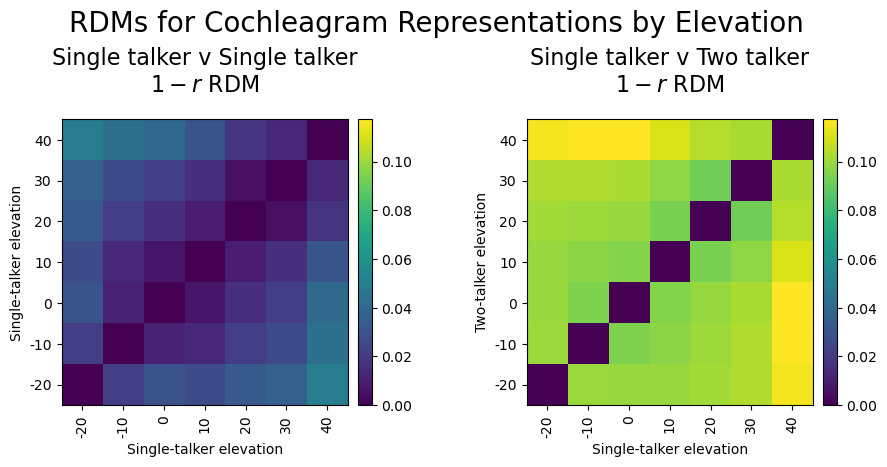

In [ ]:
# plot the rdms, for representations for locations
single_src_coch_reps = embeddings['norm_coch_rep_target_single_source']
multi_src_coch_reps = embeddings['norm_coch_rep_mixture_same_sex_single_source']

# --- collect elevations ---
all_locs = list(loc_to_idx.keys())
elevations = [loc for loc in all_locs if (loc == (0, 0) or (loc[0] == 0) and loc[1] != 0)]
loc_labels = [f"{loc[1]:.0f}" for loc in elevations]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
n = len(elevations)

xlabel = "Single-talker elevation"
pearson_r_matrix = np.full((2, n, n), np.nan, dtype=float)
l2_dist_matrix  = np.full((2, n, n), np.nan, dtype=float)
for plt_i in range(2):
    X = single_src_coch_reps
    if plt_i == 0:
        Y = single_src_coch_reps
    elif plt_i == 1:
        Y = multi_src_coch_reps
    for i in range(n):
        Xi = X[loc_to_idx[elevations[i]]]  # (N, D)
        pearson_r_matrix[plt_i, i, i] = 0 # is 1 - r where r = 1 
        l2_dist_matrix[plt_i, i, i]   = 0.0
        for j in range(i):
            Xj = Y[loc_to_idx[elevations[j]]]  # (N, D)
            r  = pearson_r(Xi, Xj)
            d  = l2_dist(Xi, Xj)
            pearson_r_matrix[plt_i, i, j] = pearson_r_matrix[plt_i, j, i] = 1 - r
            l2_dist_matrix[plt_i, i, j]   = l2_dist_matrix[plt_i, j, i]   = d

    # plot_lower_triangle(l2_dist_matrix,   f"{panel_title}\nL2 Distance RDM",  loc_labels, xlabel=xlabel, ylabel=ylabel, cmap='viridis', ax=axes[0, plt_i], vmin=0)

elev_vmin = np.nanmin(pearson_r_matrix)
elev_vmax = np.nanmax(pearson_r_matrix)

# flip columns so diagonal goes bottom to top 
pearson_r_matrix = np.flip(pearson_r_matrix, axis=1)
for plt_i in range(2):
    ylabel = "Single-talker elevation" if plt_i == 0 else "Two-talker elevation"
    panel_title = "Single talker v Single talker" if plt_i == 0 else "Single talker v Two talker"
    # flip columns 
    plot_lower_triangle(pearson_r_matrix[plt_i,:,:], f"{panel_title}\n$1-r$ RDM", 
                         xtick_labels=loc_labels,
                         ytick_labels=loc_labels[::-1],
                         xlabel=xlabel, ylabel=ylabel,
                        cmap='viridis', ax=axes[plt_i], vmin=elev_vmin, vmax=elev_vmax, symmetric=True)

plt.suptitle("RDMs for Cochleagram Representations by Elevation", fontsize=20, y=1)
# adjust hspace
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.tight_layout()
# plt.savefig(outdir / "cochleagram_elev_rdm.pdf", bbox_inches='tight', transparent=True)